In [ ]:
# ==================== INSTALL & IMPORT ====================
!pip install yfinance pandas numpy matplotlib -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries installed and imported successfully!")

✅ Libraries installed and imported successfully!


In [ ]:
# ==================== FETCH GOOGL DATA ====================
print("📊 Fetching GOOGL data (10 years)...")
ticker = "GOOGL"
data = yf.download(ticker, start="2015-01-01", end=None)
print(f"✅ Downloaded {len(data)} days of data")
print("Columns available:", data.columns.tolist())
print(data.tail())

📊 Fetching GOOGL data (10 years)...


[*********************100%***********************]  1 of 1 completed

✅ Downloaded 2781 days of data
Columns available: [('Close', 'GOOGL'), ('High', 'GOOGL'), ('Low', 'GOOGL'), ('Open', 'GOOGL'), ('Volume', 'GOOGL')]
Price            Close        High         Low        Open    Volume
Ticker           GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
Date                                                                
2026-01-16  330.000000  334.649994  327.700012  334.410004  40341600
2026-01-20  322.000000  327.730011  320.429993  320.869995  35361000
2026-01-21  328.380005  332.480011  319.350006  320.920013  35386600
2026-01-22  330.540009  335.149994  328.750000  334.450012  26166200
2026-01-23  328.630005  333.688904  327.450012  332.484985  16577886


In [ ]:
# ==================== CALCULATE TECHNICAL INDICATORS ====================
print("📈 Calculating technical indicators...")

import numpy as np
import pandas as pd
import yfinance as yf
import ast

TICKER = "GOOGL"  # <-- set your ticker


# ---------- 1) Clean OHLCV from yfinance ----------
# To avoid inheriting broken structures.
raw = yf.download(TICKER, period="10y", interval="1d", auto_adjust=False, progress=False)
if raw is None or raw.empty:
    raise ValueError("yfinance download returned empty data. Check ticker or try again later.")

df = raw.copy()

# ---------- 2) Repair columns if they are stringified tuples ----------
# Example columns for now:
# ["('Adj Close', 'GOOGL')", "('Close', 'GOOGL')", ...]
def parse_tuple_col(c):
    if isinstance(c, str) and c.startswith("(") and c.endswith(")"):
        try:
            t = ast.literal_eval(c)
            if isinstance(t, tuple) and len(t) == 2:
                return t
        except Exception:
            return c
    return c

df.columns = [parse_tuple_col(c) for c in df.columns]

# If columns became real tuples, turn them into a MultiIndex
if all(isinstance(c, tuple) and len(c) == 2 for c in df.columns):
    df.columns = pd.MultiIndex.from_tuples(df.columns)

# ---------- 3) If MultiIndex, select the correct level ----------
# Handle (Field, Ticker) or (Ticker, Field)
if isinstance(df.columns, pd.MultiIndex):
    lvl0 = df.columns.get_level_values(0)
    lvln = df.columns.get_level_values(-1)

    # Case: (Field, Ticker)
    if TICKER in set(lvln):
        df = df.xs(TICKER, axis=1, level=-1)
    # Case: (Ticker, Field)
    elif TICKER in set(lvl0):
        df = df.xs(TICKER, axis=1, level=0)
    else:
        # fallback: keep last level
        df.columns = lvln

# ---------- 4) Standardize OHLCV names ----------
df.columns = [str(c).strip() for c in df.columns]

rename = {}
for c in df.columns:
    lc = c.lower().replace("_", " ").strip()
    if lc == "open": rename[c] = "Open"
    elif lc == "high": rename[c] = "High"
    elif lc == "low": rename[c] = "Low"
    elif lc == "close": rename[c] = "Close"
    elif lc in ["adj close", "adjusted close", "adjclose"]: rename[c] = "Adj Close"
    elif lc == "volume": rename[c] = "Volume"
df = df.rename(columns=rename)

# Ensure datetime index and numeric
df.index = pd.to_datetime(df.index, errors="coerce")
df = df.sort_index()
for c in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if not (("Close" in df.columns) or ("Adj Close" in df.columns)):
    raise ValueError(f"Still no Close/Adj Close after repair. Columns now: {list(df.columns)}")

close_col = "Adj Close" if "Adj Close" in df.columns else "Close"
prices = df[close_col]
print(f"Using column '{close_col}' for calculations")


# ---------- 5) Indicator functions ----------
def sma(s: pd.Series, n: int) -> pd.Series:
    return s.rolling(n, min_periods=n).mean()

def calculate_rsi(prices: pd.Series, window: int = 14) -> pd.Series:
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = (-delta).clip(lower=0)
    avg_gain = gain.ewm(alpha=1/window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, adjust=False).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def calculate_macd(prices: pd.Series, slow: int = 26, fast: int = 12, signal: int = 9):
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def calculate_bollinger_bands(prices: pd.Series, window: int = 20, num_std: float = 2.0):
    mid = prices.rolling(window, min_periods=window).mean()
    std = prices.rolling(window, min_periods=window).std()
    upper = mid + num_std * std
    lower = mid - num_std * std
    return upper, mid, lower


# ---------- 6) Compute indicators ----------
data = df.copy()  # keep pipeline variable name

data["SMA_20"] = sma(prices, 20)
data["SMA_50"] = sma(prices, 50)
data["RSI"] = calculate_rsi(prices, 14)

macd_line, signal_line, macd_hist = calculate_macd(prices)
data["MACD"] = macd_line
data["MACD_signal"] = signal_line
data["MACD_hist"] = macd_hist

bb_upper, bb_mid, bb_lower = calculate_bollinger_bands(prices, 20, 2.0)
data["BB_upper"] = bb_upper
data["BB_middle"] = bb_mid
data["BB_lower"] = bb_lower

print("✅ Indicators calculated!")
print(data[[close_col, "SMA_20", "SMA_50", "RSI", "MACD", "MACD_signal", "MACD_hist"]].tail())


📈 Calculating technical indicators...
Using column 'Adj Close' for calculations
✅ Indicators calculated!
             Adj Close      SMA_20      SMA_50        RSI      MACD  \
Date                                                                  
2026-01-16  330.000000  319.511501  309.274797  64.042841  7.429937   
2026-01-20  322.000000  320.488501  310.032314  53.503296  6.518558   
2026-01-21  328.380005  321.549501  310.908637  59.261325  6.239175   
2026-01-22  330.540009  322.587502  311.946483  61.021264  6.121491   
2026-01-23  328.630005  323.301501  312.720876  58.610096  5.807163   

            MACD_signal  MACD_hist  
Date                                
2026-01-16     6.496866   0.933071  
2026-01-20     6.501205   0.017353  
2026-01-21     6.448799  -0.209624  
2026-01-22     6.383337  -0.261846  
2026-01-23     6.268102  -0.460939  


In [ ]:
# Fix cell - error from a broken quote in the print line.

import pandas as pd
import numpy as np

def pick_col(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

close_col = pick_col(data, ["Adj Close", "Close", "close", "adj_close", "adj close"])
if close_col is None:
    raise ValueError("No close column found. Expected Close/Adj Close.")

data[close_col] = pd.to_numeric(data[close_col], errors="coerce")

# SMAs
if "SMA_50" not in data.columns:
    data["SMA_50"] = data[close_col].rolling(window=50, min_periods=50).mean()

if "SMA_200" not in data.columns:
    data["SMA_200"] = data[close_col].rolling(window=200, min_periods=200).mean()

# RSI
if "RSI" not in data.columns:
    def calculate_rsi(prices: pd.Series, window: int = 14) -> pd.Series:
        prices = pd.to_numeric(prices, errors="coerce")
        delta = prices.diff()
        gain = delta.clip(lower=0)
        loss = (-delta).clip(lower=0)
        avg_gain = gain.ewm(alpha=1/window, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/window, adjust=False).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50.0)

    data["RSI"] = calculate_rsi(data[close_col], window=14)

# MACD hist
if "MACD_hist" not in data.columns:
    def calculate_macd(prices: pd.Series, slow: int = 26, fast: int = 12, signal: int = 9):
        prices = pd.to_numeric(prices, errors="coerce")
        exp1 = prices.ewm(span=fast, adjust=False).mean()
        exp2 = prices.ewm(span=slow, adjust=False).mean()
        macd_line = exp1 - exp2
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        hist = macd_line - signal_line
        return macd_line, signal_line, hist

    macd_line, macd_signal, macd_hist = calculate_macd(data[close_col])
    data["MACD"] = macd_line
    data["MACD_signal"] = macd_signal
    data["MACD_hist"] = macd_hist

print("✅ Missing indicators (if any) have been created.")
print(data[[close_col, "SMA_50", "SMA_200", "RSI", "MACD_hist"]].tail())


✅ Missing indicators (if any) have been created.
             Adj Close      SMA_50     SMA_200        RSI  MACD_hist
Date                                                                
2026-01-16  330.000000  309.274797  226.113914  64.042841   0.933071
2026-01-20  322.000000  310.032314  226.940876  53.503296   0.017353
2026-01-21  328.380005  310.908637  227.831252  59.261325  -0.209624
2026-01-22  330.540009  311.946483  228.757956  61.021264  -0.261846
2026-01-23  328.630005  312.720876  229.669377  58.610096  -0.460939


In [ ]:
# ==================== GENERATE TRADING SIGNALS (OPTIMIZED: RISK OVERLAY) ====================
import numpy as np
import pandas as pd

def pick_col(df, names):
    for n in names:
        if n in df.columns:
            return n
    raise ValueError(f"Missing columns. Expected one of: {names}")

# Select columns
close_col = pick_col(data, ["Adj Close", "Close", "close", "adj_close", "adj close"])
high_col  = pick_col(data, ["High", "high"])
low_col   = pick_col(data, ["Low", "low"])

# Ensure numeric
close = pd.to_numeric(data[close_col], errors="coerce")
high  = pd.to_numeric(data[high_col], errors="coerce")
low   = pd.to_numeric(data[low_col], errors="coerce")

# --- Parameters (these are what you "optimize") ---
SMA_SLOW = 200
VOL_LOOKBACK = 20          # daily vol lookback
VOL_Q = 0.70               # high-vol threshold percentile (rolling)
REB_FREQ = "W-FRI"         # rebalance weekly (Fri close)
VOL_TARGET_ANN = 0.18      # set None to disable vol targeting
MAX_LEV = 1.25

# Exposure scalars by regime
EXP_BULL_LOWVOL  = 1.10    # slightly above 1 in good regime
EXP_BULL_HIGHVOL = 0.60
EXP_BEAR_LOWVOL  = 0.30
EXP_BEAR_HIGHVOL = 0.00

# --- Compute features needed for regime ---
data = data.copy()
data["ret"] = close.pct_change().fillna(0.0)
data["SMA_200"] = close.rolling(SMA_SLOW, min_periods=SMA_SLOW).mean()

# Trend regime
data["trend"] = (close > data["SMA_200"]).astype(int)  # 1=bull, 0=bear

# Vol regime: compare current vol vs rolling quantile of vol
vol_d = data["ret"].rolling(VOL_LOOKBACK, min_periods=VOL_LOOKBACK).std()
data["vol_ann"] = (vol_d * np.sqrt(252)).replace(0, np.nan)

vol_thr = data["vol_ann"].rolling(252, min_periods=60).quantile(VOL_Q)
data["high_vol"] = (data["vol_ann"] > vol_thr).astype(int)  # 1=high vol

# Regime scalar (risk overlay)
def regime_scalar(trend, high_vol):
    if trend == 1 and high_vol == 0:
        return EXP_BULL_LOWVOL
    if trend == 1 and high_vol == 1:
        return EXP_BULL_HIGHVOL
    if trend == 0 and high_vol == 0:
        return EXP_BEAR_LOWVOL
    return EXP_BEAR_HIGHVOL

data["regime_scalar"] = [
    regime_scalar(int(t), int(hv)) for t, hv in zip(data["trend"], data["high_vol"])
]

# Optional vol targeting (stabilize risk). If disabled -> base_lev=1.
if VOL_TARGET_ANN is None:
    data["base_lev"] = 1.0
else:
    data["base_lev"] = (VOL_TARGET_ANN / data["vol_ann"]).clip(upper=MAX_LEV).fillna(0.0)

# Target exposure before rebalance
data["target_exposure"] = (data["base_lev"] * data["regime_scalar"]).clip(0.0, MAX_LEV)

# Weekly rebalance: only change position on rebalance dates
reb_dates = data.resample(REB_FREQ).last().index
data["rebalance_flag"] = data.index.isin(reb_dates).astype(int)

pos = np.zeros(len(data), dtype=float)
for i in range(1, len(data)):
    pos[i] = pos[i-1]
    if data["rebalance_flag"].iloc[i] == 1:
        pos[i] = float(data["target_exposure"].iloc[i])

data["position"] = pos
data["position_lag"] = data["position"].shift(1).fillna(0.0)

print("✅ Optimized risk overlay positions generated.")
print("Avg exposure:", round(float(data["position_lag"].mean()), 3))
print("Rebalance count:", int(data["rebalance_flag"].sum()))


✅ Optimized risk overlay positions generated.
Avg exposure: 0.612
Rebalance count: 507


In [ ]:
# ==================== BACKTEST (WITH COSTS) ====================
cost_bps = 5.0
slippage_bps = 2.0

data["turnover"] = (data["position"].fillna(0.0) - data["position_lag"].fillna(0.0)).abs()
data["tcost"] = data["turnover"] * ((cost_bps + slippage_bps) / 10_000.0)

# IMPORTANT: no lookahead
data["strat_ret"] = data["position_lag"] * data["ret"] - data["tcost"]

data["equity_strat"] = (1 + data["strat_ret"]).cumprod()
data["equity_bh"] = (1 + data["ret"]).cumprod()
data["dd_strat"] = data["equity_strat"] / data["equity_strat"].cummax() - 1.0

def perf(bt):
    r = bt["strat_ret"].dropna()
    years = len(r) / 252.0
    total = float(bt["equity_strat"].iloc[-1] - 1)
    bh_total = float(bt["equity_bh"].iloc[-1] - 1)
    ann = float((1 + total) ** (1/years) - 1) if years > 0 else np.nan
    sharpe = float((r.mean()/r.std()) * np.sqrt(252)) if r.std() != 0 else np.nan
    mdd = float(bt["dd_strat"].min())
    trades = int((bt["turnover"] > 0).sum())
    return total, ann, sharpe, mdd, trades, bh_total

total, ann, sharpe, mdd, trades, bh_total = perf(data)

print("\nBACKTEST PERFORMANCE")
print(f"Total Return: {total*100:.1f}%")
print(f"Annualized Return: {ann*100:.1f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Maximum Drawdown: {mdd*100:.1f}%")
print(f"Trade Days (turnover>0): {trades}")
print("\nBenchmark Comparison")
print(f"Strategy Return: {total*100:.1f}%")
print(f"Buy & Hold Return: {bh_total*100:.1f}%")
print(f"Total Return Diff (Strat - B&H): {(total-bh_total)*100:.1f}%")



BACKTEST PERFORMANCE
Total Return: 510.8%
Annualized Return: 19.9%
Sharpe Ratio: 1.10
Maximum Drawdown: -18.9%
Trade Days (turnover>0): 398

Benchmark Comparison
Strategy Return: 510.8%
Buy & Hold Return: 802.7%
Total Return Diff (Strat - B&H): -291.9%


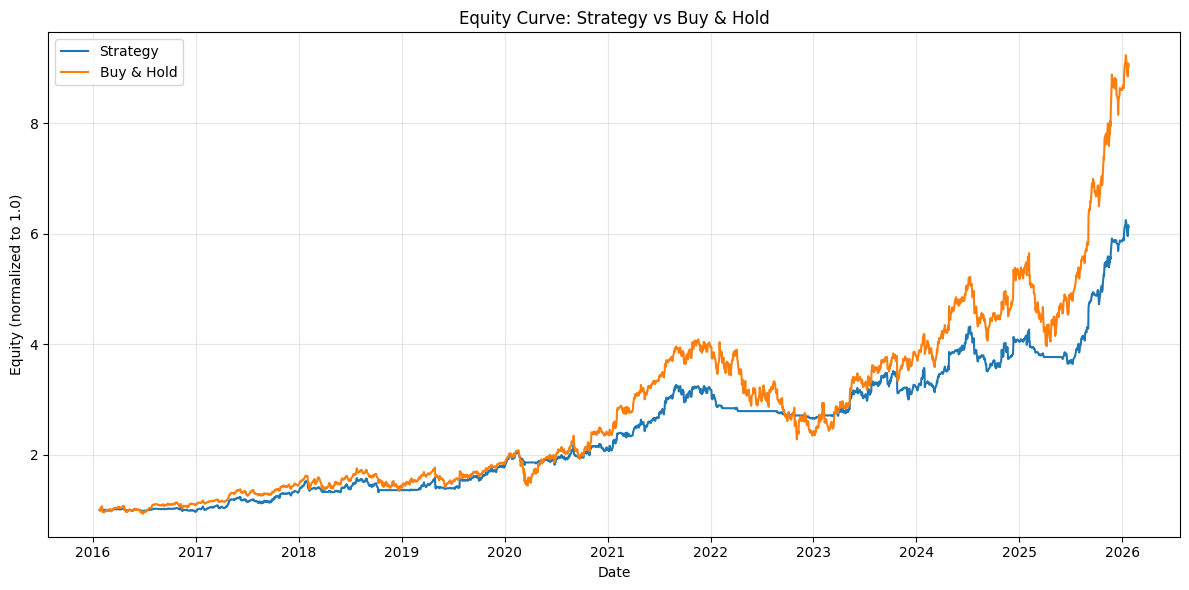

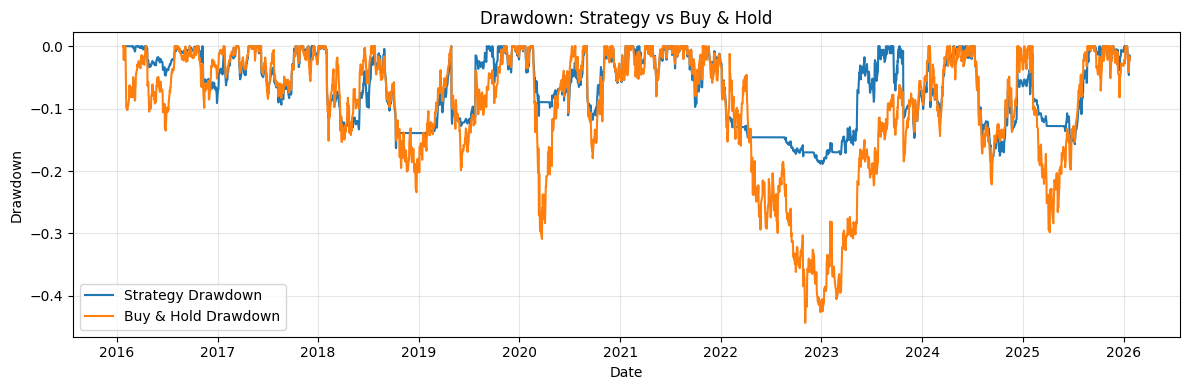

In [ ]:
# ==================== EQUITY CURVE + DRAWDOWN CHARTS ====================
# Assumes you already ran the backtest and have:
# data["equity_strat"], data["equity_bh"], data["dd_strat"]
# If your buy&hold drawdown is also desired, this cell will compute it.

import numpy as np
import matplotlib.pyplot as plt

# --- sanity checks ---
need = ["equity_strat", "equity_bh"]
missing = [c for c in need if c not in data.columns]
if missing:
    raise ValueError(f"Missing columns for plotting: {missing}. Run backtest first.")

# --- compute buy&hold drawdown (optional but useful) ---
if "dd_bh" not in data.columns:
    peak_bh = data["equity_bh"].cummax()
    data["dd_bh"] = data["equity_bh"] / peak_bh - 1.0

# 1) Equity curve comparison
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["equity_strat"], label="Strategy")
plt.plot(data.index, data["equity_bh"], label="Buy & Hold")
plt.title("Equity Curve: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Equity (normalized to 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Drawdown comparison (optional but recommended)
plt.figure(figsize=(12, 4))
plt.plot(data.index, data["dd_strat"], label="Strategy Drawdown")
plt.plot(data.index, data["dd_bh"], label="Buy & Hold Drawdown")
plt.title("Drawdown: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


📊 Creating visualizations...


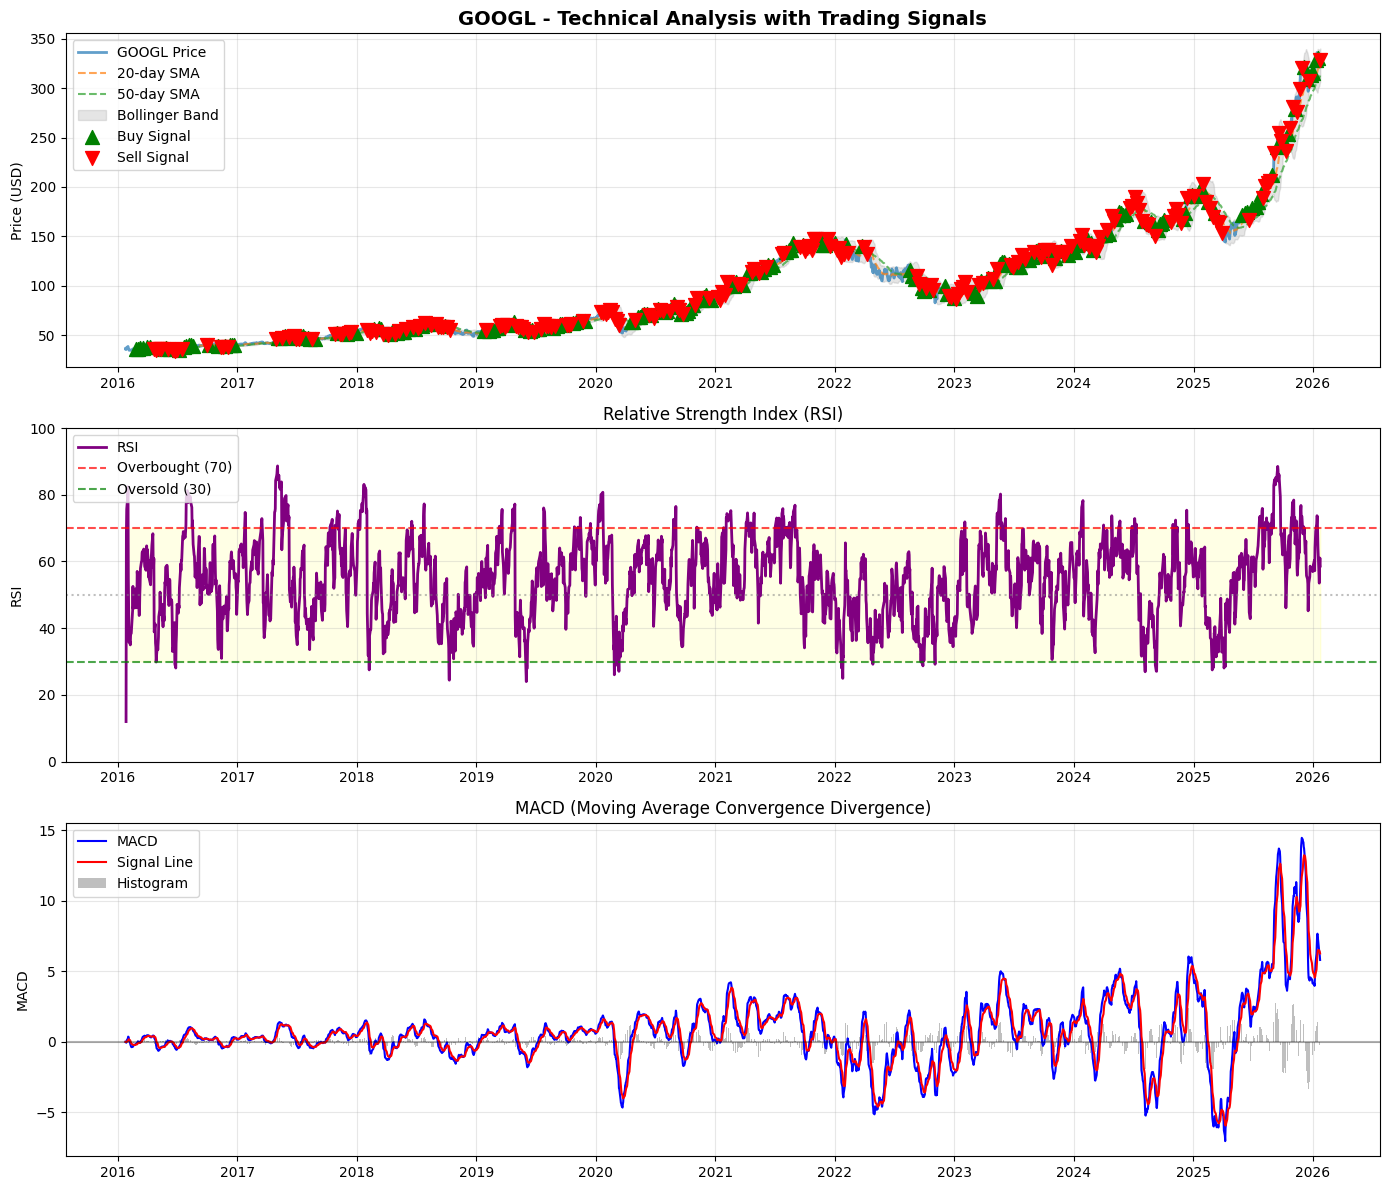

✅ Visualizations saved as 'googl_technical_analysis.png'


In [ ]:
# ==================== VISUALIZATION ====================
print("📊 Creating visualizations...")

# --- Generate 'Action' column based on position changes for visualization ---
# This logic assumes 'position' from the backtest indicates exposure.
# 'position' is the current holding. 'position_lag' is the holding from the previous period.
data['Action'] = 'HOLD' # Default action if no change

# Buy if current position is greater than previous position (implies entry or increase in holding)
data.loc[data['position'] > data['position_lag'], 'Action'] = 'BUY'

# Sell if current position is less than previous position (implies exit or decrease in holding)
data.loc[data['position'] < data['position_lag'], 'Action'] = 'SELL'

# Ensure 'Action' column doesn't have NaN values that would break the plotting filter
data['Action'] = data['Action'].fillna('HOLD')
# -------------------------------------------------------------------------

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Price with SMA and signals
axes[0].plot(data[close_col], label=f'{ticker} Price', alpha=0.7, linewidth=2)
axes[0].plot(data['SMA_20'], label='20-day SMA', linestyle='--', alpha=0.7)
axes[0].plot(data['SMA_50'], label='50-day SMA', linestyle='--', alpha=0.7)
axes[0].fill_between(data.index, data['BB_upper'], data['BB_lower'], alpha=0.2, color='gray', label='Bollinger Band')
buy_signals = data[data['Action'] == 'BUY']
sell_signals = data[data['Action'] == 'SELL']
axes[0].scatter(buy_signals.index, buy_signals[close_col], color='green', label='Buy Signal', marker='^', s=100, zorder=5)
axes[0].scatter(sell_signals.index, sell_signals[close_col], color='red', label='Sell Signal', marker='v', s=100, zorder=5)
axes[0].set_title(f'{ticker} - Technical Analysis with Trading Signals', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: RSI
axes[1].plot(data['RSI'], label='RSI', color='purple', linewidth=2)
axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
axes[1].axhline(y=50, color='gray', linestyle=':', alpha=0.5)
axes[1].fill_between(data.index, 30, 70, alpha=0.1, color='yellow')
axes[1].set_title('Relative Strength Index (RSI)', fontsize=12)
axes[1].set_ylabel('RSI')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 100)

# Plot 3: MACD
axes[2].plot(data['MACD'], label='MACD', color='blue', linewidth=1.5)
axes[2].plot(data['MACD_signal'], label='Signal Line', color='red', linewidth=1.5)
axes[2].bar(data.index, data['MACD_hist'], label='Histogram', color='gray', alpha=0.5, width=1)
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[2].set_title('MACD (Moving Average Convergence Divergence)', fontsize=12)
axes[2].set_ylabel('MACD')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('googl_technical_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Visualizations saved as 'googl_technical_analysis.png'")

🎨 Creating visualizations...


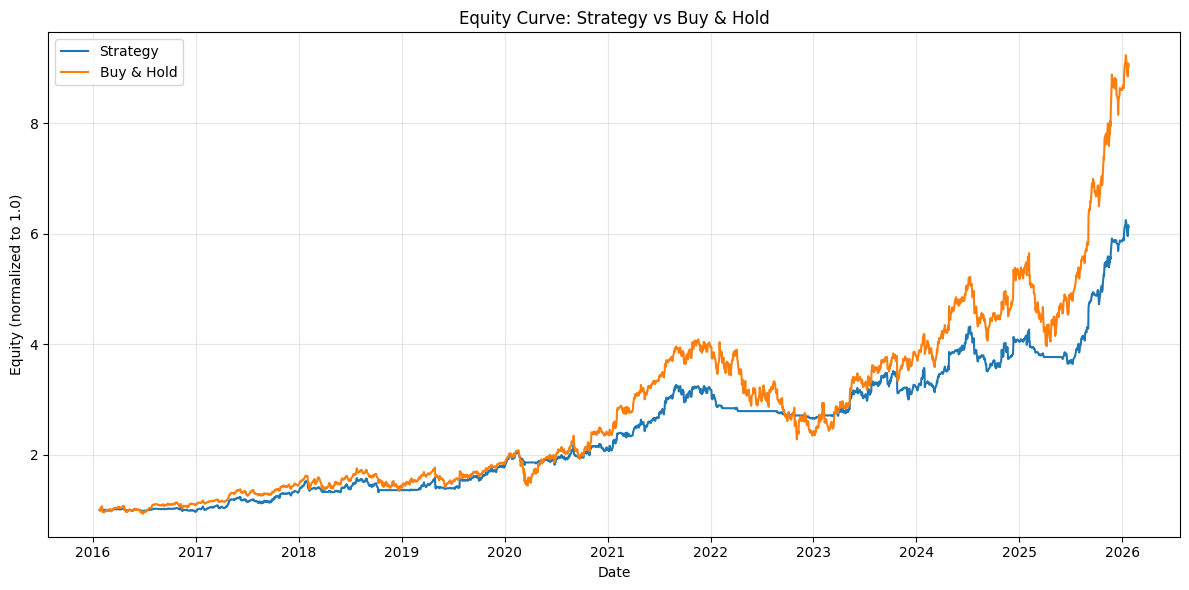

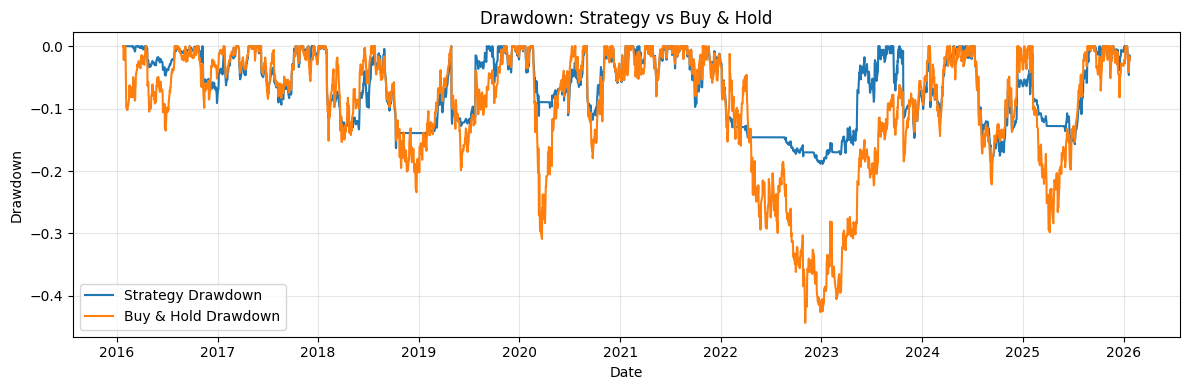

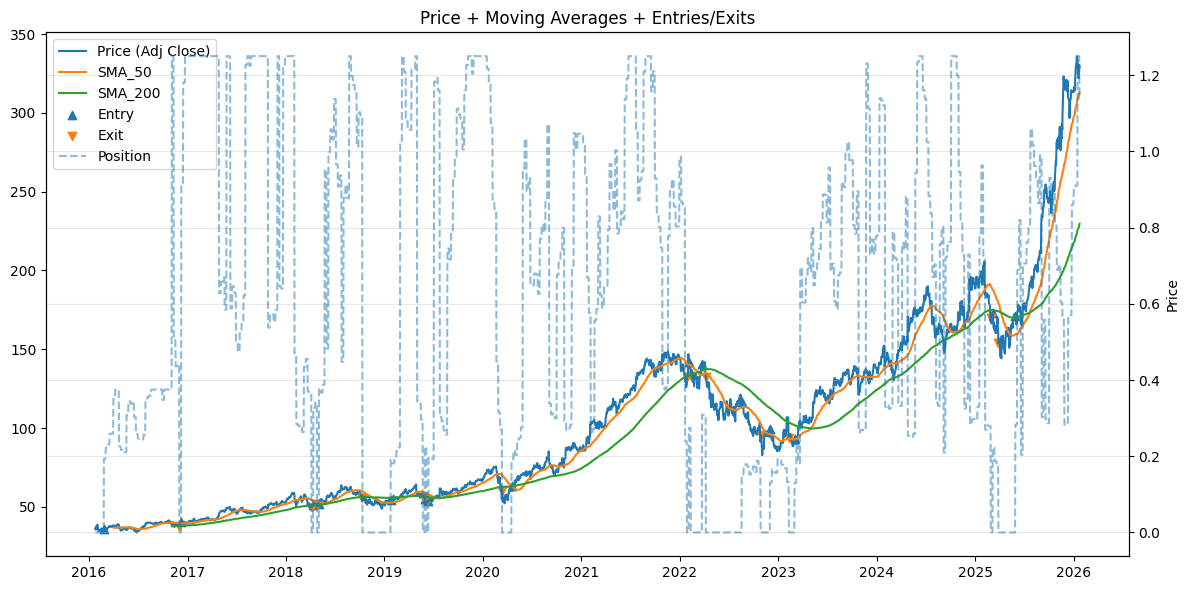

✅ Visualizations created.


In [ ]:
# ==================== VISUALIZATION ====================
# Visualization block that WILL NOT require an 'Action' column.
# It will:
# 1) Plot equity curve (Strategy vs Buy&Hold)
# 2) Plot drawdown curve (Strategy vs Buy&Hold)
# 3) Plot price + moving averages + entry/exit markers derived from position changes (if available)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("🎨 Creating visualizations...")

# ---- helpers ----
def pick_col(df, names, default=None):
    for n in names:
        if n in df.columns:
            return n
    return default

def ensure_series(x):
    if isinstance(x, pd.DataFrame):
        raise ValueError("Expected a Series but got a DataFrame. Check your column selection.")
    return x

# ---- 0) Basic checks ----
eq_strat_col = pick_col(data, ["equity_strat", "Equity_Strategy", "strategy_equity"])
eq_bh_col    = pick_col(data, ["equity_bh", "Equity_BH", "buyhold_equity"])

if eq_strat_col is None or eq_bh_col is None:
    raise ValueError(
        "Missing equity columns. Run your backtest first to create:\n"
        "- data['equity_strat']\n"
        "- data['equity_bh']\n"
        "(and ideally data['dd_strat'])."
    )

dd_strat_col = pick_col(data, ["dd_strat", "Drawdown_Strategy"])
dd_bh_col    = pick_col(data, ["dd_bh", "Drawdown_BH"])  # optional

# ---- 1) Equity curve: Strategy vs Buy & Hold ----
plt.figure(figsize=(12, 6))
plt.plot(data.index, data[eq_strat_col], label="Strategy")
plt.plot(data.index, data[eq_bh_col], label="Buy & Hold")
plt.title("Equity Curve: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Equity (normalized to 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---- 2) Drawdown plot (recommended; will compute BH drawdown if missing) ----
if dd_strat_col is not None:
    # compute BH drawdown if not present
    if dd_bh_col is None:
        peak_bh = data[eq_bh_col].cummax()
        data["dd_bh"] = data[eq_bh_col] / peak_bh - 1.0
        dd_bh_col = "dd_bh"

    plt.figure(figsize=(12, 4))
    plt.plot(data.index, data[dd_strat_col], label="Strategy Drawdown")
    plt.plot(data.index, data[dd_bh_col], label="Buy & Hold Drawdown")
    plt.title("Drawdown: Strategy vs Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ data['dd_strat'] not found. Skipping drawdown chart. (Recommended to compute drawdown in backtest.)")

# ---- 3) Price chart + MAs + Entry/Exit markers (derived from 'position' changes) ----
close_col = pick_col(data, ["Adj Close", "Close", "close", "adj_close", "adj close"])
if close_col is None:
    # fallback: try any numeric column that looks like price
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    close_col = numeric_cols[0] if numeric_cols else None

ma50_col  = pick_col(data, ["SMA_50", "ma50", "MA_50"])
ma200_col = pick_col(data, ["SMA_200", "ma200", "MA_200"])

pos_col = pick_col(data, ["position", "Position", "pos", "exposure"])

if close_col is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[close_col], label=f"Price ({close_col})")

    if ma50_col is not None:
        plt.plot(data.index, data[ma50_col], label=ma50_col)
    if ma200_col is not None:
        plt.plot(data.index, data[ma200_col], label=ma200_col)

    # Entry/Exit markers from position changes (no Action column needed)
    if pos_col is not None:
        pos = ensure_series(data[pos_col].fillna(0.0))
        pos_prev = pos.shift(1).fillna(0.0)

        entries = data.index[(pos_prev == 0) & (pos != 0)]
        exits   = data.index[(pos_prev != 0) & (pos == 0)]

        if len(entries) > 0:
            plt.scatter(entries, data.loc[entries, close_col], marker="^", label="Entry")
        if len(exits) > 0:
            plt.scatter(exits, data.loc[exits, close_col], marker="v", label="Exit")

        # Optional: show position on secondary axis
        ax = plt.gca()
        ax2 = ax.twinx()
        ax2.plot(data.index, pos, linestyle="--", alpha=0.5, label="Position")
        ax2.set_ylabel("Position / Exposure")
        # combine legends
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    else:
        plt.legend()

    plt.title("Price + Moving Averages + Entries/Exits")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Could not find a close/price column for the price chart. Skipping price visualization.")

print("✅ Visualizations created.")


In [ ]:
# ==================== HELPER: RESOLVE TICKER + DISPLAY NAME ====================
import pandas as pd
import yfinance as yf

def resolve_ticker_and_name(
    data: pd.DataFrame,
    ticker: str | None = None,
    display_name_override: str | None = None,
):
    """
    Returns:
      ticker_used: str (upper)
      display_name: str (override > yfinance longName/shortName > ticker)
    """
    # 1) Determine ticker
    ticker_used = (ticker or "").strip().upper()
    if not ticker_used:
        # try global fallback
        ticker_used = str(globals().get("ticker", "")).strip().upper() or "UNKNOWN"

    # 2) Determine display name
    if display_name_override and display_name_override.strip():
        display_name = display_name_override.strip()
        return ticker_used, display_name

    display_name = None
    try:
        info = yf.Ticker(ticker_used).info
        display_name = info.get("longName") or info.get("shortName")
    except Exception:
        display_name = None

    if not display_name:
        display_name = ticker_used

    return ticker_used, display_name


In [ ]:
# ==================== Colab setup: install SDK + set API key + quick test ====================

# 1) Install OpenAI SDK (and optional dotenv)
!pip -q install -U openai python-dotenv

# 2) Set OPENAI_API_KEY (hidden input)
from getpass import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass("Enter OPENAI_API_KEY (hidden): ")
print("OPENAI_API_KEY set:", bool(os.environ.get("OPENAI_API_KEY")))

# 3) (Optional) choose a model
os.environ["OPENAI_MODEL"] = "gpt-4o-mini"  # or "gpt-4o"

# 4) Quick sanity test (makes a real API call)
from openai import OpenAI

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
resp = client.responses.create(
    model=os.environ["OPENAI_MODEL"],
    input="Reply with exactly: OK",
    max_output_tokens=20,
)
print(resp.output_text)


Enter OPENAI_API_KEY (hidden): ··········
OPENAI_API_KEY set: True
OK


In [ ]:
# ==================== 6. LLM TRADE NOTE ====================
print("🤖 Generating trade note...")

import os
import numpy as np
import pandas as pd

# ---------- (A) Helper: flatten columns ----------
def flatten_cols(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = df.columns.get_level_values(-1)
    df.columns = [str(c).strip() for c in df.columns]
    return df

data = flatten_cols(data).sort_index().copy()

# ---------- (B) Helper: pick columns ----------
def pick_col(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

# ---------- (C) Helper: resolve ticker + display name (works even without yfinance) ----------
def resolve_ticker_and_name(ticker: str | None = None, display_name_override: str | None = None):
    ticker_used = (ticker or str(globals().get("ticker", "")) or "").strip().upper()
    if not ticker_used:
        ticker_used = "GOOGL"  # fallback ONLY if user did not provide any ticker at all

    if display_name_override and display_name_override.strip():
        return ticker_used, display_name_override.strip()

    # Try yfinance name lookup if available; otherwise fallback to ticker
    display_name = None
    try:
        import yfinance as yf
        info = yf.Ticker(ticker_used).info
        display_name = info.get("longName") or info.get("shortName")
    except Exception:
        display_name = None

    return ticker_used, (display_name or ticker_used)

ticker_used, display_name = resolve_ticker_and_name(
    ticker=globals().get("ticker", None),
    display_name_override=None
)

# ---------- (D) Ensure minimal backtest columns exist (self-heal) ----------
close_col = pick_col(data, ["Adj Close", "Close", "close", "adj_close", "adj close"])
if close_col is None:
    raise ValueError("No close column found. Need Close/Adj Close.")

close = pd.to_numeric(data[close_col], errors="coerce")

if "ret" not in data.columns:
    data["ret"] = close.pct_change().fillna(0.0)

# Exposure: prefer position/BT_exposure; if missing, assume buy&hold exposure=1.0 (so report still works)
pos_col = pick_col(data, ["BT_exposure", "position", "position_lag", "exposure", "pos"])
if pos_col is None:
    data["position"] = 1.0
    pos_col = "position"

# Build position_lag
if "position_lag" in data.columns:
    pos_lag = pd.to_numeric(data["position_lag"], errors="coerce").fillna(0.0)
else:
    pos = pd.to_numeric(data[pos_col], errors="coerce").fillna(0.0)
    pos_lag = pos.shift(1).fillna(0.0)
    data["position_lag"] = pos_lag

# Costs (optional): use existing, else assume 0
cost_col = pick_col(data, ["BT_cost", "tcost", "cost"])
if cost_col is None:
    data["BT_cost"] = 0.0
    cost_col = "BT_cost"

# Strategy returns: use existing, else compute
ret_col = pick_col(data, ["BT_ret_net", "strat_ret", "strat_ret_net", "strategy_ret"])
if ret_col is None:
    data["BT_ret_net"] = pos_lag * data["ret"] - pd.to_numeric(data[cost_col], errors="coerce").fillna(0.0)
    ret_col = "BT_ret_net"

# Strategy equity: use existing, else compute
eq_col = pick_col(data, ["BT_equity", "equity_strat", "equity", "Equity"])
if eq_col is None:
    data["BT_equity"] = (1.0 + pd.to_numeric(data[ret_col], errors="coerce").fillna(0.0)).cumprod()
    eq_col = "BT_equity"

# Buy&hold equity
if "equity_bh" not in data.columns:
    data["equity_bh"] = (1.0 + data["ret"]).cumprod()

# ---------- (E) Metrics ----------
def cagr(eq: pd.Series, periods_per_year=252):
    eq = eq.dropna()
    if len(eq) < 2:
        return np.nan
    years = (len(eq) - 1) / periods_per_year
    return (eq.iloc[-1] ** (1/years) - 1) if years > 0 else np.nan

def sharpe(r: pd.Series, periods_per_year=252):
    r = r.dropna()
    return (r.mean()/r.std()) * np.sqrt(periods_per_year) if r.std() != 0 else np.nan

def max_dd(eq: pd.Series):
    eq = eq.dropna()
    if eq.empty:
        return np.nan
    dd = eq / eq.cummax() - 1.0
    return float(dd.min())

eq_s = pd.to_numeric(data[eq_col], errors="coerce")
r_s  = pd.to_numeric(data[ret_col], errors="coerce")
eq_bh = pd.to_numeric(data["equity_bh"], errors="coerce")

TotalReturn = float(eq_s.dropna().iloc[-1] - 1.0)
CAGR = float(cagr(eq_s))
Sharpe = float(sharpe(r_s))
MaxDD = float(max_dd(eq_s))
BH_TotalReturn = float(eq_bh.dropna().iloc[-1] - 1.0)

# Latest snapshot
last = data.dropna(subset=[close_col]).iloc[-1]
rsi_val = float(last.get("RSI", np.nan))
macd_hist_val = float(last.get("MACD_hist", np.nan))
sma50_val = float(last.get("SMA_50", np.nan))
sma200_val = float(last.get("SMA_200", np.nan))
position_val = float(last.get("position", last.get("BT_exposure", np.nan)))
regime_scalar_val = float(last.get("regime_scalar", np.nan))

# ---------- (F) Prompt ----------
prompt = f"""
You are a buy-side Technical Analyst Agent. Write a 1–2 page TRADE NOTE in Markdown.

Ticker: {ticker_used}
Company: {display_name}
Last date: {str(last.name.date()) if hasattr(last.name, 'date') else str(last.name)}
Last close ({close_col}): {float(last[close_col])}

LATEST INDICATORS (if available):
- RSI(14): {rsi_val}
- MACD hist: {macd_hist_val}
- SMA_50: {sma50_val}
- SMA_200: {sma200_val}
- Position/Exposure: {position_val}
- Regime scalar (risk overlay): {regime_scalar_val}

BACKTEST METRICS (strategy):
- Total return: {TotalReturn:.4f}
- CAGR: {CAGR:.4f}
- Sharpe: {Sharpe:.4f}
- Max drawdown: {MaxDD:.4f}
- Buy & hold total return: {BH_TotalReturn:.4f}

REQUIRED STRUCTURE:
1) Executive Summary
2) Regime and Momentum
3) Signal read-through
4) Trade recommendation (entry/exit triggers, risk)
5) Backtest evidence (brief)
6) Key risks and failure modes
7) Assumptions (bullets)

Rules:
- Use only the provided metrics/values; do not fabricate numbers.
- Keep ~700–1100 words.
""".strip()

# ---------- (G) OpenAI call (REPLACES the entire Gemini section) ----------
out_path = f"{ticker_used.lower()}_trade_note.md"

# Use OPENAI_API_KEY (set it via env var / .env / Colab secret)
openai_key = (os.environ.get("OPENAI_API_KEY") or "").strip()

if not openai_key:
    with open(out_path, "w", encoding="utf-8") as f:
        f.write("OpenAI trade note not generated because OPENAI_API_KEY is not set.\n\n")
        f.write("Set before this cell:\n")
        f.write("  import os\n  os.environ['OPENAI_API_KEY'] = 'YOUR_KEY'\n")
    print(f"⚠️ OPENAI_API_KEY not set. Wrote placeholder: {out_path}")
else:
    # Install/import OpenAI SDK (works in Colab/Jupyter)
    try:
        from openai import OpenAI
    except Exception:
        !pip -q install openai
        from openai import OpenAI

    client = OpenAI(api_key=openai_key)

    # Model fallback list (cheapest first)
    models_to_try = [
        os.environ.get("OPENAI_MODEL", "").strip() or "gpt-4o-mini",
        "gpt-4o",
    ]

    max_retries_per_model = 4
    base_sleep = 1.0

    last_err = None
    note = ""

    for model_name in models_to_try:
        for attempt in range(max_retries_per_model):
            try:
                resp = client.responses.create(
                    model=model_name,
                    input=[{"role": "user", "content": prompt}],
                    temperature=0.4,
                    max_output_tokens=1400,
                )
                note = (getattr(resp, "output_text", "") or "").strip()
                if note:
                    print(f"✅ OpenAI succeeded with model={model_name} on attempt {attempt+1}.")
                    break
                last_err = RuntimeError(f"Empty response from model={model_name}")
            except Exception as e:
                last_err = e

                # Do NOT retry insufficient_quota (won't recover by waiting)
                msg = str(e)
                if "insufficient_quota" in msg:
                    raise RuntimeError(
                        "OpenAI API error: insufficient_quota (no available API credits / budget). "
                        "Check OpenAI Platform billing/usage or use a key/project with available quota."
                    ) from e

                # Retry other transient errors with exponential backoff
                sleep_s = base_sleep * (2 ** attempt)
                print(f"⚠️ OpenAI error (model={model_name}) attempt {attempt+1}/{max_retries_per_model}: {repr(e)}")
                time.sleep(sleep_s)

        if note:
            break

    if not note:
        raise RuntimeError(f"OpenAI failed after retries. Last error: {repr(last_err)}")

    with open(out_path, "w", encoding="utf-8") as f:
        f.write(note)

    print(f"✅ Trade note saved to: {out_path}")

# Small diagnostic so you can confirm it used real columns
print("Diagnostics:",
      f"ticker_used={ticker_used}, display_name={display_name}, close_col={close_col}, eq_col={eq_col}, ret_col={ret_col}")

🤖 Generating trade note...
✅ OpenAI succeeded with model=gpt-4o-mini on attempt 1.
✅ Trade note saved to: googl_trade_note.md
Diagnostics: ticker_used=GOOGL, display_name=Alphabet Inc., close_col=Adj Close, eq_col=equity_strat, ret_col=strat_ret


In [ ]:
# ==================== EXPORT RESULTS ====================
# Never assumes df['equity'] / df['exposure'] exist.
# If missing, it rebuilds: ret, position_lag, tcost (optional), strat_ret, equity_strat, equity_bh.

import numpy as np
import pandas as pd
from datetime import datetime

print("\n💾 Exporting results (self-healing)...")

# -------- helpers --------
def flatten_cols(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = df.columns.get_level_values(-1)
    df.columns = [str(c).strip() for c in df.columns]
    return df

def pick_col(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

def safe_num(s):
    return pd.to_numeric(s, errors="coerce")

# -------- normalize data --------
data = flatten_cols(data).sort_index().copy()

ticker_str = "googl"
if "ticker" in globals() and isinstance(ticker, str) and ticker.strip():
    ticker_str = ticker.strip().lower()

# -------- locate key columns --------
close_col = pick_col(data, ["Adj Close", "Close", "close", "adj_close", "adj close"])
high_col  = pick_col(data, ["High", "high"])
low_col   = pick_col(data, ["Low", "low"])

if close_col is None:
    raise ValueError("Cannot export: no Close/Adj Close column found in `data`.")

close = safe_num(data[close_col])

# -------- ensure returns --------
if "ret" not in data.columns:
    data["ret"] = close.pct_change().fillna(0.0)

# -------- ensure position / exposure --------
# prefer BT_exposure -> position -> exposure -> Position
pos_col = pick_col(data, ["position", "BT_exposure", "exposure", "Position", "pos"])
if pos_col is None:
    # if no position, create a buy&hold position (1.0) so exports still work
    data["position"] = 1.0
    pos_col = "position"

# Make sure it's numeric and finite
data[pos_col] = safe_num(data[pos_col]).fillna(0.0)

# Standardize to data["BT_exposure"]
data["BT_exposure"] = data[pos_col].astype(float)

# -------- ensure position_lag --------
if "position_lag" not in data.columns:
    data["position_lag"] = data["BT_exposure"].shift(1).fillna(0.0)

# -------- ensure transaction cost column --------
# If already computed costs in backtest, keep them; else set to 0 or compute from turnover with default bps.
cost_col_existing = pick_col(data, ["BT_cost", "tcost", "cost", "transaction_cost"])
if cost_col_existing is not None:
    data["BT_cost"] = safe_num(data[cost_col_existing]).fillna(0.0)
else:
    # default: compute costs from turnover with conservative assumptions
    trade_cost_bps = float(globals().get("trade_cost_bps", 0.0))  # if you have it
    slippage_bps   = float(globals().get("slippage_bps", 0.0))    # if you have it
    # If you did not define them, default to 0 to avoid “fake” costs
    total_bps = (trade_cost_bps + slippage_bps) / 10_000.0

    data["turnover"] = (data["BT_exposure"] - data["position_lag"]).abs()
    data["BT_cost"] = data["turnover"] * total_bps

# -------- ensure strategy returns + equity --------
ret_col_existing = pick_col(data, ["BT_ret_net", "strat_ret", "strat_ret_net", "strategy_ret"])
if ret_col_existing is not None:
    data["BT_ret_net"] = safe_num(data[ret_col_existing]).fillna(0.0)
else:
    # compute from position_lag and ret
    data["BT_ret_net"] = data["position_lag"] * data["ret"] - data["BT_cost"]

eq_col_existing = pick_col(data, ["BT_equity", "equity_strat", "equity", "Equity"])
if eq_col_existing is not None:
    data["BT_equity"] = safe_num(data[eq_col_existing]).fillna(method="ffill").fillna(1.0)
else:
    data["BT_equity"] = (1.0 + data["BT_ret_net"]).cumprod()

# Buy & hold equity
if "equity_bh" not in data.columns:
    data["equity_bh"] = (1.0 + data["ret"]).cumprod()

# Drawdown (strategy)
if "dd_strat" not in data.columns:
    data["dd_strat"] = data["BT_equity"] / data["BT_equity"].cummax() - 1.0

# -------- export signals (last 100 rows, only if columns exist) --------
candidate_cols = [
    close_col,
    "SMA_20","SMA_50","SMA_200",
    "RSI","MACD","MACD_signal","MACD_hist",
    "BB_upper","BB_middle","BB_lower",
    "entry_signal","rebalance_flag",
    "BT_exposure","position_lag","BT_ret_net","BT_cost","BT_equity","equity_bh","dd_strat"
]
cols_present = [c for c in candidate_cols if c in data.columns]
signals_df = data[cols_present].tail(100).copy()

signals_path = f"{ticker_str}_trading_signals.csv"
signals_df.to_csv(signals_path)
print(f"✅ Signals saved: {signals_path} (cols={len(cols_present)})")

# -------- summary stats export --------
r = data["BT_ret_net"].dropna()
eq = data["BT_equity"].dropna()

years = len(r) / 252.0 if len(r) else np.nan
total_strategy_return_decimal = float(eq.iloc[-1] - 1.0) if len(eq) else np.nan
annualized_return = float((1.0 + total_strategy_return_decimal) ** (1/years) - 1) if np.isfinite(years) and years > 0 else np.nan
sharpe_ratio_val = float((r.mean() / r.std()) * np.sqrt(252)) if r.std() != 0 else np.nan
max_drawdown_strategy_val = float(data["dd_strat"].min()) if "dd_strat" in data.columns else np.nan

bh_total = float(data["equity_bh"].dropna().iloc[-1] - 1.0) if data["equity_bh"].notna().any() else np.nan
num_trades_val = int((data["BT_exposure"].diff().abs().fillna(0.0) > 0).sum())

current_price = float(close.dropna().iloc[-1])
current_rsi = float(data["RSI"].dropna().iloc[-1]) if "RSI" in data.columns and data["RSI"].notna().any() else np.nan

summary_stats = {
    "Ticker": ticker_str.upper(),
    "Analysis_Period": f"{data.index.min().date()} to {data.index.max().date()}",
    "Analysis_Date": datetime.now().strftime("%Y-%m-%d"),
    "Current_Price": f"{current_price:.2f}",
    "Strategy_Total_Return_Pct": f"{total_strategy_return_decimal*100:.1f}%" if np.isfinite(total_strategy_return_decimal) else "N/A",
    "Strategy_Annualized_Return_Pct": f"{annualized_return*100:.1f}%" if np.isfinite(annualized_return) else "N/A",
    "BuyHold_Total_Return_Pct": f"{bh_total*100:.1f}%" if np.isfinite(bh_total) else "N/A",
    "Sharpe_Ratio": f"{sharpe_ratio_val:.2f}" if np.isfinite(sharpe_ratio_val) else "N/A",
    "Max_Drawdown_Pct": f"{max_drawdown_strategy_val*100:.1f}%" if np.isfinite(max_drawdown_strategy_val) else "N/A",
    "Trade_Days_Turnover_gt0": num_trades_val,
    "RSI_Current": f"{current_rsi:.1f}" if np.isfinite(current_rsi) else "N/A",
}

summary_path = f"{ticker_str}_analysis_summary.csv"
pd.DataFrame([summary_stats]).to_csv(summary_path, index=False)
print(f"✅ Summary saved: {summary_path}")

# -------- trade log export (derived from exposure changes) --------
ex = data["BT_exposure"].fillna(0.0)
ex_prev = ex.shift(1).fillna(0.0)

entries = data.index[(ex_prev == 0) & (ex != 0)]
exits   = data.index[(ex_prev != 0) & (ex == 0)]
n = min(len(entries), len(exits))

trade_log = pd.DataFrame({
    "entry_date": entries[:n],
    "exit_date": exits[:n],
    "entry_exposure": ex.loc[entries[:n]].values if n > 0 else [],
    "exit_exposure": ex.loc[exits[:n]].values if n > 0 else [],
})

trade_log_path = f"{ticker_str}_trade_log.csv"
trade_log.to_csv(trade_log_path, index=False)
print(f"✅ Trade log saved: {trade_log_path}")

print("✅ Export completed.")
print("Diagnostics:",
      f"close_col={close_col}, pos_source={pos_col},",
      f"BT_equity_last={data['BT_equity'].dropna().iloc[-1]:.4f}",
      f"trades={num_trades_val}")


💾 Exporting results (self-healing)...
✅ Signals saved: googl_trading_signals.csv (cols=19)
✅ Summary saved: googl_analysis_summary.csv
✅ Trade log saved: googl_trade_log.csv
✅ Export completed.
Diagnostics: close_col=Adj Close, pos_source=position, BT_equity_last=6.1075 trades=398


In [ ]:
# ==================== FINAL OUTPUT ====================
# Fixes:
# - trades may be an int (or not exist) -> no .empty error
# - 'Action' column may not exist -> sample print won't KeyError
# - close_col may be tuple (MultiIndex) -> handled

import numpy as np
import pandas as pd

print("\n" + "="*60)
print(" AI TECHNICAL ANALYST AGENT ")
print("="*60)

# ---- safe checks ----
has_trade_df = ("trades" in globals()) and isinstance(trades, pd.DataFrame) and (not trades.empty)

# Determine ticker string for file naming
ticker_str = "googl"
if "ticker" in globals() and isinstance(ticker, str) and ticker.strip():
    ticker_str = ticker.strip().lower()

print("\n📁 FILES GENERATED:")
print(f"1. {ticker_str}_technical_analysis.png - Visualization charts (if you saved a PNG)")
print(f"2. {ticker_str}_trade_note.md - Detailed trade note")
print(f"3. {ticker_str}_trading_signals.csv - Latest 100 trading signals")
print(f"4. {ticker_str}_analysis_summary.csv - Performance metrics summary")
if has_trade_df:
    print(f"5. {ticker_str}_trade_log.csv - Complete trade history")

# ---- Key metrics (use what exists; fall back safely) ----
def safe_float(x, default=np.nan):
    try:
        return float(x)
    except Exception:
        return default

# These variables may or may not exist depending on your notebook
current_signal_val = globals().get("current_signal", "N/A")
current_price_val = safe_float(globals().get("current_price", np.nan))
total_return_val = globals().get("total_strategy_return_decimal", np.nan)
sharpe_val = globals().get("sharpe_ratio_val", np.nan)
current_rsi_val = globals().get("current_rsi", np.nan)
num_trades_val = globals().get("num_trades_val", globals().get("num_trades", "N/A"))

# Trend label: prefer SMA_50 vs SMA_200 if available
trend_label = "N/A"
if "SMA_50" in data.columns and "SMA_200" in data.columns:
    try:
        trend_label = "Bullish" if float(data["SMA_50"].dropna().iloc[-1]) > float(data["SMA_200"].dropna().iloc[-1]) else "Bearish"
    except Exception:
        pass
elif "SMA_20" in data.columns and "SMA_50" in data.columns:
    try:
        trend_label = "Bullish" if float(data["SMA_20"].dropna().iloc[-1]) > float(data["SMA_50"].dropna().iloc[-1]) else "Bearish"
    except Exception:
        pass

print("\n📊 KEY METRICS:")
print(f"   • Final Recommendation: {current_signal_val}")
print(f"   • Current Price: {current_price_val:.2f}" if np.isfinite(current_price_val) else "   • Current Price: N/A")
print(f"   • Strategy Total Return: {safe_float(total_return_val) * 100:.1f}%" if np.isfinite(safe_float(total_return_val)) else "   • Strategy Total Return: N/A")
print(f"   • Sharpe Ratio: {safe_float(sharpe_val):.2f}" if np.isfinite(safe_float(sharpe_val)) else "   • Sharpe Ratio: N/A")
print(f"   • Current RSI: {safe_float(current_rsi_val):.1f}" if np.isfinite(safe_float(current_rsi_val)) else "   • Current RSI: N/A")
print(f"   • Number of Trades: {num_trades_val}")
print(f"   • Market Trend: {trend_label}")
print("="*60)

# ---- Sample data (no 'Action' required) ----
# close_col may be stored earlier as a tuple (MultiIndex) or a string.
# If not available, infer.
def pick_col(df, names):
    for n in names:
        if n in df.columns:
            return n
    return None

close_col_local = globals().get("close_col", None)
if close_col_local is None or (isinstance(close_col_local, str) and close_col_local not in data.columns):
    close_col_local = pick_col(data, ["Adj Close", "Close", "close", "adj_close", "adj close"])

# Build sample columns list safely
sample_cols = []
if close_col_local is not None:
    sample_cols.append(close_col_local)

for c in ["SMA_20", "SMA_50", "SMA_200", "RSI", "MACD", "MACD_signal", "MACD_hist", "position", "BT_exposure"]:
    if c in data.columns:
        sample_cols.append(c)

print("\n📋 SAMPLE DATA (Last 5 days):")
if sample_cols:
    print(data[sample_cols].tail())
else:
    print(data.tail())

# Optional: show last signal state if your strategy uses position
if "position" in data.columns:
    print("\n📌 Latest position/exposure:", float(pd.to_numeric(data["position"], errors="coerce").fillna(0.0).iloc[-1]))


 AI TECHNICAL ANALYST AGENT 

📁 FILES GENERATED:
1. googl_technical_analysis.png - Visualization charts (if you saved a PNG)
2. googl_trade_note.md - Detailed trade note
3. googl_trading_signals.csv - Latest 100 trading signals
4. googl_analysis_summary.csv - Performance metrics summary

📊 KEY METRICS:
   • Final Recommendation: N/A
   • Current Price: 328.63
   • Strategy Total Return: 510.8%
   • Sharpe Ratio: 1.10
   • Current RSI: 58.6
   • Number of Trades: 398
   • Market Trend: Bullish

📋 SAMPLE DATA (Last 5 days):
             Adj Close      SMA_20      SMA_50     SMA_200        RSI  \
Date                                                                    
2026-01-16  330.000000  319.511501  309.274797  226.113914  64.042841   
2026-01-20  322.000000  320.488501  310.032314  226.940876  53.503296   
2026-01-21  328.380005  321.549501  310.908637  227.831252  59.261325   
2026-01-22  330.540009  322.587502  311.946483  228.757956  61.021264   
2026-01-23  328.630005  323.30150